# Kopp et al 2021 Intepretation
**Authorship:**
Adam Klie, *08/12/2022*
***
**Description:**
Notebook to interpret the best trained models on the Kopp et al (2021) dataset.
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import glob
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


In [2]:
# Configure EUGENe 
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene/kopp21"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/kopp21"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/kopp21"
eu.settings.config_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/kopp21"
eu.settings.figure_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/figures/kopp21"
eu.settings.verbosity = logging.ERROR

# Load in the `leaf`, `proto` and `combined` test `SeqData`s 

In [49]:
# Load in the preprocessed training data
sdata_test = eu.dl.read_h5sd(
    filename=os.path.join(eu.settings.output_dir, "jund_test_predictions_all.h5sd"),
)

# Load the best model

In [57]:
model_type = "Kopp21CNN"
trial = 4

In [59]:
model_file = glob.glob(os.path.join(eu.settings.logging_dir, f"{model_type}", f"trial_{trial}", "checkpoints", "*"))[0]
model = eu.models.Kopp21CNN.load_from_checkpoint(model_file)
model

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Kopp21CNN(
  (hp_metric): AUROC()
  (conv): Conv1d(4, 10, kernel_size=(11,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=30, stride=1, padding=0, dilation=1, ceil_mode=False)
  (batchnorm): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(10, 8, kernel_size=(3,), stride=(1,))
  (batchnorm2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=8, out_features=1, bias=True)
)

## Feature attribution

In [60]:
saliency_methods = ["InputXGradient", "GradientSHAP"]
for method in saliency_methods:
    eu.interpret.feature_attribution_sdata(
        model,
        sdata_test,
        method=method
    )

No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/502 [00:00<?, ?it/s]

No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/502 [00:00<?, ?it/s]

## Filter viz (only for convnet)

In [61]:
eu.interpret.generate_pfms_sdata(
    model, 
    sdata_test,
    method="Minnoye20"
)

No transforms given, assuming just need to tensorize.


Getting maximial activating seqlets:   0%|          | 0/502 [00:00<?, ?it/s]

Getting filter activators for 10 filters:   0%|          | 0/10 [00:00<?, ?it/s]

Getting PFMs from filters:   0%|          | 0/10 [00:00<?, ?it/s]

In [62]:
# Save all the filter pfms from above as meme format for submission to TomTom
eu.dl.motif.filters_to_meme_sdata(
    sdata_test,
    filter_ids=list(sdata_test.uns["pfms"].keys()),
    output_dir=os.path.join(eu.settings.output_dir),
    file_name=f"jund_best_{model_type}_model_filters.meme"
)

Saved PWM File as : /cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/kopp21/jund_best_Kopp21CNN_model_filters.meme


In [63]:
# Save the test intepretations for this model
sdata_test.write_h5sd(os.path.join(eu.settings.output_dir, f"jund_test_predictions_and_interpretations_{model_type}.h5sd"))

## In silico interpretation

In [44]:
# Prep feature from meme file
meme = eu.dl.motif.MinimalMEME(path=os.path.join(eu.settings.dataset_dir, "MA0491.1.meme"))
motif = meme.motifs["MA0491.1"]
feat_name = motif.name
pfm = motif.pfm
zero_pfm = np.zeros(pfm.shape)
rand_pfm = eu.pp.ohe_seq(eu.utils.random_seq(pfm.shape[0])).transpose()
rc_pfm = eu.pp.reverse_complement_seq(pfm)
consensus = motif.consensus
#shuffled_pfm = eu.pp.ohe_seq(eu.pp.dinuc_shuffle_seq(consensus)).transpose()
shuffled_pfm = eu.pp.ohe_seq("GTGGACTCATC").transpose()
feat_name, pfm, rc_pfm, consensus

('JUND',
 array([[0.320046, 0.019607, 0.352364, 0.307982],
        [0.391708, 0.124619, 0.483673, 0.      ],
        [0.      , 0.      , 0.      , 1.      ],
        [0.      , 0.      , 1.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      ],
        [0.      , 0.590468, 0.363679, 0.045854],
        [0.      , 0.      , 0.      , 1.      ],
        [0.039964, 0.960036, 0.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      ],
        [0.      , 0.132679, 0.059442, 0.807879],
        [0.14947 , 0.38636 , 0.32108 , 0.14309 ]]),
 array([[0.14309 , 0.32108 , 0.38636 , 0.14947 ],
        [0.807879, 0.059442, 0.132679, 0.      ],
        [0.      , 0.      , 0.      , 1.      ],
        [0.      , 0.      , 0.960036, 0.039964],
        [1.      , 0.      , 0.      , 0.      ],
        [0.045854, 0.363679, 0.590468, 0.      ],
        [0.      , 0.      , 0.      , 1.      ],
        [0.      , 1.      , 0.      , 0.      ],
        [1.      , 0.      , 0.      , 

In [39]:
random_seqs = eu.pp.ohe_seqs(eu.utils.random_seqs(10, 500))
sdata_implant = eu.dl.SeqData(ohe_seqs=random_seqs)
sdata_implant.seqs_annot.index = "random" + sdata_implant.seqs_annot.index
sdata_implant.names = sdata_implant.seqs_annot.index
eu.pp.reverse_complement_seqs_sdata(sdata_implant)

One-hot encoding sequences:   0%|          | 0/10 [00:00<?, ?it/s]

SeqData object modified:
	ohe_rev_seqs: None -> 10 ohe_rev_seqs added


In [45]:
# Slide the jund motif across the sequences
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_implant, 
    feature=pfm, 
    seqsm_key=f"slide_{feat_name}",
    encoding="onehot", 
    onehot=True
)

# Slide a random seq across the sequences
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_implant, 
    feature=rand_pfm,
    seqsm_key=f"slide_random",
    encoding="onehot", 
    onehot=True
)

# Slide a zero ohe seq across the sequences 
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_implant, 
    feature=zero_pfm,
    seqsm_key=f"slide_zero",
    encoding="onehot", 
    onehot=True
)

# Slide a jund shuffled ohe seq across the sequences 
eu.interpret.feature_implant_seqs_sdata(
    model=model, 
    sdata=sdata_implant, 
    feature=shuffled_pfm,
    seqsm_key=f"slide_shuffled",
    encoding="onehot", 
    onehot=True
)

Implanting feature in all seqs of sdata:   0%|          | 0/10 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/10 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/10 [00:00<?, ?it/s]

Implanting feature in all seqs of sdata:   0%|          | 0/10 [00:00<?, ?it/s]

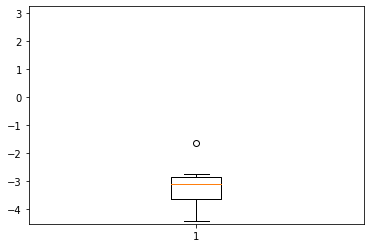

In [46]:
plt.boxplot(
    model(
        torch.from_numpy(sdata_implant.ohe_seqs).float().to(model.device), 
        torch.from_numpy(sdata_implant.ohe_rev_seqs).float().to(model.device)
    ).detach().cpu().numpy(),
)
plt.ylim(-4.519107693374157, 3.2380127858519554)
plt.savefig(os.path.join(eu.settings.figure_dir, "jund_best_CNN_model_random_seq_scores.pdf"))

ylim (-4.424650456476956, 3.0610449718870223)


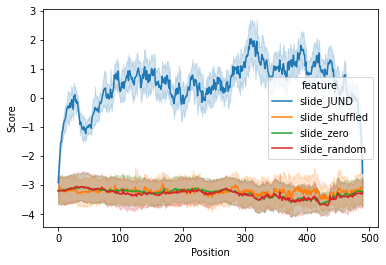

In [56]:
eu.pl.feature_implant_plot(
    sdata_implant,
    seqsm_keys=[f"slide_{feat_name}", "slide_shuffled", "slide_zero", "slide_random"],
    save=os.path.join(eu.settings.figure_dir, f"jund_best_CNN_model_feature_implant_jund.pdf")
)

In [48]:
sdata_implant.write_h5sd(os.path.join(eu.settings.output_dir, "jund_implant_feat_CNN.h5sd"))

---

# Scratch